# Group Details

## Group Name: Group 08

### Student 1: Jasper Linders

### Student 2: Alexander Liu

### Student 3: Sjoerd van Straten

# Loading Data and Preliminaries

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [6]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""
example = load_array('data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [7]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.
"""

example = load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Data Handling and Preprocessing

First, let's import the data and make variables for the train and test data.

In [8]:
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset

class ImportData(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = sorted(os.listdir(folder_path))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        data, label = load_array(file_path, task='task 2')
        return data, label

# Create an instance of the custom dataset class with the folder path
train_import = ImportData('data/task 2_3/train/')
test_import = ImportData('data/task 2_3/test/')

X_train_import = []
y_train_import = []
X_test_import = []
y_test_import = []

# Iterate through the train_dataset to extract data and labels
for data, label in train_import:
    X_train_import.append(data)
    y_train_import.append(label)

for data, label in test_import:
    X_test_import.append(data)
    y_test_import.append(label)

max_length = 9
max_seq = 49

# Pad the data samples with zeros to have the same shape
X_train_padded = []
for data in X_train_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_train_padded.append(padded_data)

y_train_padded = []
for label in y_train_import:
    pad_width = max_length - label.shape[0]
    pad_length = max_seq - label.shape[1]
    padded_label = np.pad(label, ((0, pad_width), (0, pad_length), (0,0)), mode='constant')
    y_train_padded.append(padded_label)

X_test_padded = []
for data in X_test_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_test_padded.append(padded_data)

y_test_padded = []
for label in y_test_import:
    pad_width = max_length - label.shape[0]
    pad_length = max_seq - label.shape[1]
    padded_label = np.pad(label, ((0, pad_width), (0, pad_length), (0,0)), mode='constant')
    y_test_padded.append(padded_label)

# Convert the padded data and labels to tensors
X_train = torch.tensor(np.array(X_train_padded))
y_train = torch.tensor(np.array(y_train_padded))
X_test = torch.tensor(np.array(X_test_padded))
y_test = torch.tensor(np.array(y_test_padded))

# Print the shape of X_train and the first label in y_train
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  torch.Size([900, 9, 5])
y_train shape:  torch.Size([900, 9, 49, 4])
X_test shape:  torch.Size([100, 9, 5])
y_test shape:  torch.Size([100, 9, 49, 4])


# Model Implementation

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on {torch.cuda.get_device_name(0)}' if torch.cuda.is_available() else 'Training on CPU')

Training on Quadro M1200


In [10]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=9*5, hidden_size=128, num_layers=49, proj_size=36, batch_first=True)
        # self.linear = nn.Linear(128, 45)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # output, (h_n, c_n) = self.linear(output), self.linear(h_n), self.linear(c_n)
        return output, (h_n, c_n)

In [16]:
model = LSTM()
output, (h_n, c_n) = model(X_train[0].flatten().unsqueeze(0).float())
output.shape, c_n.shape, h_n.shape

c:\Users\20174216\OneDrive - TU Eindhoven\Documents\1. TUe MSc DSAI\Q4\2AMM10 - Deep Learning\tue-deeplearning\.venv\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: LSTM with projections is not supported with oneDNN. Using default implementation. (Triggered internally at ..\aten\src\ATen\native\RNN.cpp:1464.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


(torch.Size([1, 36]), torch.Size([49, 128]), torch.Size([49, 36]))

In [18]:
X_train_new = torch.empty((900, 45))
y_train_new = torch.empty((900, 49, 36))

for i, X in enumerate(X_train):
    X_new = X.flatten().unsqueeze(0).float()
    X_train_new[i] = X_new

for i, y in enumerate(y_train):
    y_new = y.permute(1, 0, 2).contiguous().view(49, -1)
    y_train_new[i] = y_new

In [19]:
X_train.shape, X_train_new.shape, y_train.shape, y_train_new.shape

(torch.Size([900, 9, 5]),
 torch.Size([900, 45]),
 torch.Size([900, 9, 49, 4]),
 torch.Size([900, 49, 36]))

In [20]:
X_train = X_train_new[:700]
y_train = y_train_new[:700]
X_val = X_train_new[700:]
y_val = y_train_new[700:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([700, 45]),
 torch.Size([200, 45]),
 torch.Size([700, 49, 36]),
 torch.Size([200, 49, 36]))

In [50]:
BATCH_SIZE = 512

# Create a DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

for input, label in train_loader:
    input = input.unsqueeze(1)
    print(input.shape, label.shape)
    break

torch.Size([512, 1, 45]) torch.Size([512, 49, 36])


# Model Training

Epoch: 1/1000 	Training Loss: 16.450929 	Validation Loss: 7.667624
Epoch: 2/1000 	Training Loss: 16.557602 	Validation Loss: 7.667477
Epoch: 3/1000 	Training Loss: 16.481615 	Validation Loss: 7.667336
Epoch: 4/1000 	Training Loss: 16.604646 	Validation Loss: 7.667200
Epoch: 5/1000 	Training Loss: 16.157897 	Validation Loss: 7.667063
Epoch: 6/1000 	Training Loss: 16.440325 	Validation Loss: 7.666923
Epoch: 7/1000 	Training Loss: 16.527806 	Validation Loss: 7.666782
Epoch: 8/1000 	Training Loss: 16.577960 	Validation Loss: 7.666643
Epoch: 9/1000 	Training Loss: 16.292360 	Validation Loss: 7.666502
Epoch: 10/1000 	Training Loss: 16.150571 	Validation Loss: 7.666358
Epoch: 11/1000 	Training Loss: 16.541423 	Validation Loss: 7.666215
Epoch: 12/1000 	Training Loss: 16.016896 	Validation Loss: 7.666073
Epoch: 13/1000 	Training Loss: 16.328518 	Validation Loss: 7.665932
Epoch: 14/1000 	Training Loss: 16.385937 	Validation Loss: 7.665792
Epoch: 15/1000 	Training Loss: 16.238544 	Validation Loss

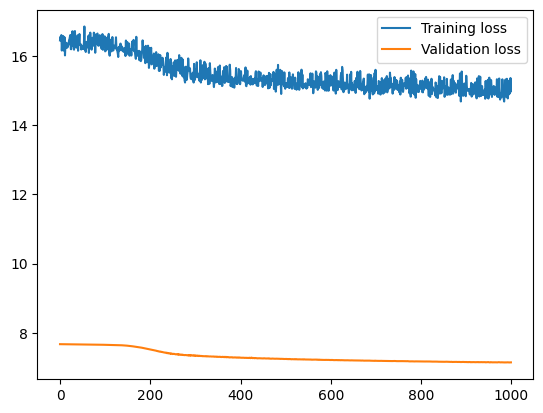

In [51]:
# Write code for the training loop
model = LSTM()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for input, label in train_loader:
        input = input.unsqueeze(1)
        input, label = input.to(device), label.to(device)
        optimizer.zero_grad()
        output, (h_n, c_n) = model(input)
        h_n = h_n.permute(1, 0, 2)
        loss = criterion(h_n, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss
    train_losses.append(train_loss)

    model.eval()
    for input, label in val_loader:
        input = input.unsqueeze(1)
        input, label = input.to(device), label.to(device)
        output, (h_n, c_n) = model(input)
        h_n = h_n.permute(1, 0, 2)
        loss = criterion(h_n, label)
        val_loss += loss.item()
    val_loss = val_loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {val_loss:.6f}')

# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [52]:
idx = 10

input = X_train[idx].unsqueeze(0).to(device)
label = y_train[idx].to(device)
output, (h_n, c_n) = model(input)
loss = criterion(h_n, label)
# loss

# print(input)
input = input.reshape((9,5))
# print(input)
# print('\n')

# print(label[0])
label = label.reshape((49, 9, 4))
# print(label[0])
# print('\n')

# print(h_n[0])
h_n = h_n.reshape((49, 9, 4))
# print(h_n[0])
# print('\n')

print(input.shape, label.shape, h_n.shape)

torch.Size([9, 5]) torch.Size([49, 9, 4]) torch.Size([49, 9, 4])


In [57]:
# This code was created with the use of ChatGPT

import matplotlib.pyplot as plt
import numpy as np

def visualize_trajectories(input_tensor, target_tensor, output_tensor):
    # Extracting starting positions from the input tensor
    start_positions = input_tensor[:, 1:3]  # Extracting x1 and y1 columns

    # Extracting mass and velocities from the input tensor
    masses = input_tensor[:, 0]
    velocities = input_tensor[:, 3:5]  # Extracting vx1 and vy1 columns

    # Extracting trajectories from the target and output tensors
    target_trajectory = target_tensor[:, :, :2]  # Extracting x2 and y2 columns
    output_trajectory = output_tensor[:, :, :2]  # Extracting x2 and y2 columns

    # Defining colors based on mass
    cmap = plt.cm.get_cmap('Dark2')
    colors = cmap(np.arange(start_positions.shape[0]))

    # Plotting the starting positions with arrows for initial velocity
    fig, ax = plt.subplots()
    for i in range(start_positions.shape[0]):
        ax.scatter(start_positions[i, 0], start_positions[i, 1], color=colors[i], s=masses[i] * 30,
                   label='Particle {}'.format(i + 1))
        ax.annotate(str(i + 1), (start_positions[i, 0], start_positions[i, 1]), color='white', ha='center', va='center')
        ax.arrow(start_positions[i, 0], start_positions[i, 1], velocities[i, 0], velocities[i, 1],
                 width=0.02, head_width=0.15, head_length=0.2, color=colors[i])

    # Plotting the target trajectory
    for i in range(target_trajectory.shape[1]):
        ax.plot(target_trajectory[:, i, 0], target_trajectory[:, i, 1], linestyle='--', linewidth=2, color=colors[i],
                alpha=0.5, label='Target Trajectory' if i == 0 else None)

    # Plotting the output trajectory
    for i in range(output_trajectory.shape[1]):
        ax.plot(output_trajectory[:, i, 0], output_trajectory[:, i, 1], linestyle='-', linewidth=2, color=colors[i],
                alpha=0.7, label='Output Trajectory' if i == 0 else None)

    # Setting plot labels, title, axes, and legend
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Particle Trajectories')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

    # Displaying the plot
    plt.show()


C:\Users\20174216\AppData\Local\Temp\ipykernel_6120\1034267259.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2')


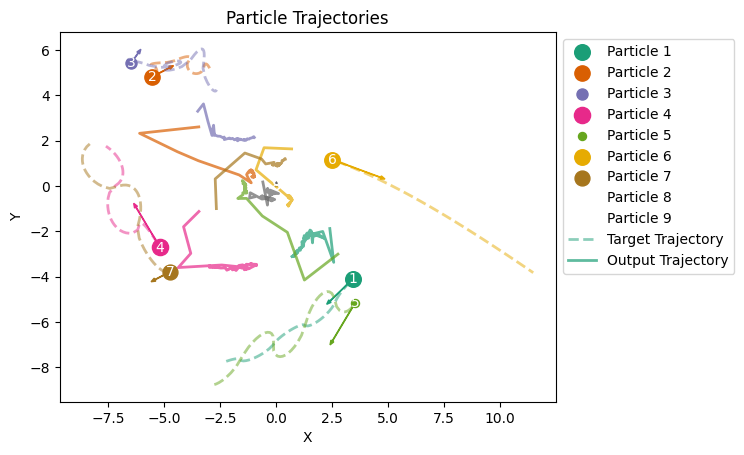

In [58]:
visualize_trajectories(input.cpu().detach().numpy(), label.cpu().detach().numpy(), h_n.cpu().detach().numpy())